# MT with terminology enforcement + informal style Post-Editing
## Task Option: d. Romance language (French) into Slavic language (Russian)

**Dataset**

503 aligned FR-RU segments, manually selected from United Nations Parallel Corpus (overshoot by 3 to make sure the fulltexts of resolutions are fed https://opus.nlpl.eu/UNPC/fr&ru/v1.0/UNPC

Motivation: terminological richness of UN texts, stylistic and terminological uniformity

**Glossary**

A 50-term glossary was extracted manually, based on background knowledge in the domain of international organisations.


**Translation**

**MT:** TowerInstruct-7B-v0.1 https://huggingface.co/Unbabel/TowerInstruct-7B-v0.1

Prompt was based on https://huggingface.co/datasets/Unbabel/TowerBlocks-v0.1/sql-console/h_zeuxO

For each segment, terms were extracted with rapidfuzz fuzzymatch, and stored along with their Russian-language equivalents


***Terminological consistency*** was ensured by adding glossary rules to TowerInstruct prompt. If a segment contained a glossary item, translation rules were added to the prompt message fed to the MT model.

Example:

"Consider the following translation rule(s):\n"Cadre d\'action de Hyogo" --> "Хиогская рамочная программа действий".\n"Annexe" --> "Приложение".\n"Déclaration de Hyogo" --> "Хиогская декларация".\n" 

**Post-Editing:** RuadaptQwen3-4B-Instruct-GGUF (8-bit quantisation) with disabled reasoning 
https://huggingface.co/RefalMachine/RuadaptQwen3-4B-Instruct-GGUF

Selected due to fast inference. Off record, IlyaGusev/saiga_nemo_12b was also checked. While more creative, one minute to process a sentence was not optimal for the available resources.

The experiments were run on Tesla V100 with 32GB VRAM via Grid5000 (student access)

**TLDR resuls**
- ***MT:***
    - COMET score: 0.7687
    - Corpus TER score: 61.06
    - Max segment TER: 500
- ***Informal PE:***
    - COMET score for MTPE: 0.1969
    - Corpus TER score: 86.86
    - Max segment TER: 1600
- **Terminological consistency:**
    - ~77.06% of term instances were featured in MT translations vs 39.63% in PE
    - translations of some terms were less consistent than others (see Terminology adherance section)g

**Possible improvements**
- Select other source text (UN language texts may not have been originally written in French)
- Input text preprocessing (cleaning, adding  missing spaces between words)
- Terminological consistancy ensurance:
  - Automatic Term Extraction
  - run queries to UNTERM portal/use existng (larger) UN term base
  - actual RAG pipeline (not tried due to time constraints), not merely prompting
- LLM MTPE output postprocessing:
  - removing additions "Французский: I. Объект"	--> "I. Объект"
  - ensuring correct capitalisation conventions: "При этом также напоминая о своих резолюциях, касающихся культуры мира,.." --> "при этом также напоминая о своих резолюциях, касающихся культуры мира,..
- Informal PE
  - larger model?"


## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", message="The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.")

In [2]:
import pandas as pd
import re
import pandas as pd
import numpy as np
import torch
import re
from rapidfuzz import fuzz

import copy
import ast
from pathlib import Path

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from tqdm import tqdm
import gc


from llama_cpp import Llama


from comet import download_model, load_from_checkpoint
from sacrebleu.metrics import TER
from sacrebleu import corpus_ter

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
sentences = Path("data/UN.fr").read_text(encoding="utf-8").strip().split("\n")
sentences[:12]

['RÉSOLUTION 62/88',
 "Adoptée à la 73e séance plénière, le 13 décembre 2007, sans avoir été mise aux voix, sur la base du projet de résolution A/62/L.31, présenté par le Président de l'Assemblée générale",
 "62/88. Déclaration de la séance plénière commémorative de haut niveau sur les suites données à la session extraordinaire de l'Assemblée générale consacrée aux enfants",
 "L'Assemblée générale",
 'Adopte la déclaration suivante :',
 "Déclaration de la séance plénière commémorative de haut niveau sur les suites données à la session extraordinaire de l'Assemblée générale consacrée aux enfants",
 "1. Nous, représentants des États rassemblés à la séance plénière commémorative de haut niveau de l'Assemblée générale, sommes encouragés par les avancées réalisées depuis 2002 sur la voie de la création d'un monde digne des enfants. Le nombre d'enfants de moins de 5 ans qui meurent chaque année a diminué. Jamais autant d'enfants n'ont été scolarisés. Les filles et les garçons se voient de pl

## Machine translation

In [ ]:
# ------------Parameters--------------
SOURCE_FILE = "data/UN-Copy1.fr"
REFERENCE_FILE = "data/UN-Copy1.ru"
GLOSSARY_FILE = "data/glossary.csv"
OUTPUT_FILE = "data/UN-Copy1.mt"
OUTPUT_FILE_PE = "data/UN_to_informal.txt"

MODEL_ID = "Unbabel/TowerInstruct-v0.1"
BATCH_SIZE = 8
MAX_NEW_TOKENS = 1256

FUZZY_THRESHOLD = 85

In [24]:
# Load model and tokenizer
pipe = pipeline("text-generation", model=MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto", do_sample=False)
tokenizer = pipe.tokenizer

We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [25]:
# -----------Load sentences------------
with open(SOURCE_FILE, encoding="utf-8") as f:
    sentences = [line.strip() for line in f if line.strip()]
with open(REFERENCE_FILE, encoding="utf-8") as f:
    references = [line.strip() for line in f if line.strip()]

# ------------Load glossary--------------
glossary_df = pd.read_csv(GLOSSARY_FILE, encoding="utf-8", names=['FR','RU'], header=None).dropna()
glossary_dict = dict(zip(glossary_df.FR, glossary_df.RU))
terms = glossary_df['FR'].dropna().unique().tolist()
regex_terms = [re.escape(t.lower()) for t in terms]

# -------------Function to find glossary terms in a sentence---------------
def find_terms_in_sentence(sentence, terms, regex_terms):
    sentence_lower = sentence.lower()
    matched_terms = set()
    for term, regex_term in zip(terms, regex_terms):
        pattern = r'\b' + regex_term + r'\b'
        if re.search(pattern, sentence_lower):
            matched_terms.add(term)
        else:
            score = fuzz.partial_ratio(term.lower(), sentence_lower)
            if score >= FUZZY_THRESHOLD:
                matched_terms.add(term)
    return list(matched_terms)

# -----------Dataset assembly--------------------
data = []
for idx, sentence in enumerate(sentences):
    source_terms = find_terms_in_sentence(sentence, terms, regex_terms)
    ref = references[idx] if idx < len(references) else ""
    target_terms = [glossary_dict[t] for t in source_terms if t in glossary_dict]
    data.append({
        "index": idx,
        "sentence": sentence,
        "ref": ref,
        "terms_source": source_terms,
        "terms_target": target_terms,
    })

ds = Dataset.from_list(data)

In [26]:
def build_prompt(example):
    sentence = example["sentence"]
    idx = example["index"]
    terms_src = example["terms_source"]
    terms_tgt = example["terms_target"]
    sentence_lower = sentence.lower()

    glossary_instruction = ""

    if terms_src:
        glossary_rules = []
        for fr_term, ru_term in zip(terms_src, terms_tgt):
            glossary_rules.append(f'"{fr_term}" --> "{ru_term}".')
        glossary_instruction = "Consider the following translation rule(s):\n" + "\n".join(glossary_rules)

    prompt = f"""
{glossary_instruction}
Translate the following sentence from French to Russian.

French: {sentence}
Russian:"""

    messages = [{"role": "user", "content": prompt.strip()}]
    full_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    return {"prompt": full_prompt}

# Applying prompts to dataset
ds = ds.map(build_prompt)



Map: 100%|██████████| 503/503 [00:00<00:00, 6362.96 examples/s]


In [31]:
ds[86]

{'index': 86,
 'sentence': "Rappelant la Déclaration de HyogoA/CONF.206/6, chap. I, résolution 1. et le Cadre d'action de Hyogo pour 2005-2015Cadre d'action de Hyogo pour 2005-2015 : Pour des nations et des collectivités résilientes face aux catastrophes (A/CONF.206/6, chap. I, résolution 2)., ainsi que la déclaration commune publiée à l'issue de la session extraordinaire sur la catastrophe de l'océan IndienDéclaration commune publiée à l'issue de la session extraordinaire sur la catastrophe de l'océan Indien : réduire les risques pour un avenir plus sûr (A/CONF.206/6, annexe II)., adoptés par la Conférence mondiale sur la prévention des catastrophes tenue à Kobe, dans la préfecture de Hyogo (Japon), du 18 au 22 janvier 2005,",
 'ref': 'ссылаясь на Хиогскую декларациюA/CONF.206/6, глава I, резолюция 1. и Хиогскую рамочную программу действий на 2005-2015 годыХиогская рамочная программа действий на 2005-2015 годы: создание потенциала противодействия бедствиям на уровне государств и общин

In [8]:
BATCH_SIZE = 16
MAX_SENTENCES = len(ds)  # len(ds) if using the whole dataset
all_translations = []

num_batches = (MAX_SENTENCES + BATCH_SIZE - 1) // BATCH_SIZE

# -------- Running batched inference ----------------------
for i in tqdm(range(0, MAX_SENTENCES, BATCH_SIZE), total=num_batches, desc="Translating", unit="batch"):
    start_time = time.time()

    batch = ds[i:i + BATCH_SIZE]
    prompts = batch["prompt"]
    outputs = pipe(prompts, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)

    for output_group in outputs:
        output = output_group[0]
        text = output["generated_text"]

        if "<|im_start|>assistant" in text:
            translation = text.split("<|im_start|>assistant")[-1].strip()
        else:
            translation = text.strip()

        translation = translation.split("<|")[0].strip()
        all_translations.append(translation)


Translating:   0%|          | 0/32 [00:00<?, ?batch/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The foll

### (skip the verbosity) 
### Saving to file 

In [9]:
# Save to file
Path(OUTPUT_FILE).write_text("\n".join(all_translations), encoding="utf-8")
print(f"✅ {len(all_translations)} translations written to {OUTPUT_FILE}")

# Free memory
del pipe, tokenizer, outputs, ds
gc.collect()
torch.cuda.empty_cache()
torch

✅ 503 translations written to data/UN-Copy1.mt


<module 'torch' from '/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/__init__.py'>

In [ ]:
fr_terms_to_csv = list(ds[:]['terms_source'])
ru_terms_to_csv = list(ds[:]['terms_target'])

## MT evaluation

### COMET

In [10]:
model_path = download_model("wmt20-comet-da")
modelEVAL = load_from_checkpoint(model_path)

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
wmt20-comet-da is already in cache.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/unbabel_comet/wmt20-comet-da/checkpoints/model.ckpt`
Encoder model frozen.
/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [11]:
cometdata = [
    {"src": s, "mt": m, "ref": r}
    for s, m, r in zip(sentences, all_translations, references)
]

model_output = modelEVAL.predict(cometdata, batch_size=8, gpus=1)  # or gpus=0 for CPU

# List of segment-level scores
segment_scores = model_output["scores"]

# Optional: average score
average_score = sum(segment_scores) / len(segment_scores)
print(f"COMET score: {average_score:.4f}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 63/63 [00:09<00:00,  6.44it/s]


COMET score: 0.7687


In [42]:
fr_terms_to_csv = list(ds[:]['terms_source'])
ru_terms_to_csv = list(ds[:]['terms_target'])

### TER

In [22]:
ter_corpus = corpus_ter(all_translations, [references])
print(f"Corpus TER score: {ter_corpus.score:.2f}")

Corpus TER score: 61.06


In [18]:
ter_metric = TER()
scores = [ter_metric.sentence_score(m, [r]).score for m, r in zip(all_translations, references)]

df = pd.DataFrame({
    "MT Output": all_translations,
    "Reference": references,
    "TER": scores
})

df.sort_values("TER", ascending=False).head(12) 

,MT Output,Reference,TER
58,Принята на 74-й пленарном заседании 17 декабря...,Принята без голосования на 74-м пленарном засе...,500.000000
421,Принята на 75-й пленарной сессии 17 декабря 20...,Принята без голосования на 75-м пленарном засе...,306.000000
294,В соответствии с Уставом Организации Объединен...,руководствуясь Уставом Организации Объединенны...,138.461538
260,constatando la importancia de mantener estrech...,отмечая важность поддержания тесного взаимодей...,129.268293
124,constatando la importancia de la cooperación i...,признавая важность международного сотрудничест...,125.000000
256,constatando con profunda preocupación que las ...,"выражая глубокую озабоченность по поводу того,...",119.444444
68,"подтверждая важность поддержки усилий, направл...",подтверждая большое значение продолжения проце...,109.090909
189,11. просит международное сообщество доноров ок...,11. призывает международное сообщество доноров...,100.000000
340,Заключили следующие обязательства:,договорились о нижеследующем:,100.000000
341,Французский: I. Объект,I. Предназначение,100.000000


## write to csv > xslx: MT

In [49]:
res_data = {
    "FR": sentences,
    "RU_GOLD": references,
    "RU_MT": all_translations,
    "FR_TERMS": fr_terms_to_csv,
    "RU_TERMS_GOLD": ru_terms_to_csv,
    "COMET_MT": segment_scores,
    "TER_MT": scores
}

res = pd.DataFrame(res_data)
res.to_csv("result.csv", index=False, encoding="utf-8")


## MTPE

## MTPE to infor,ql stylewith RuadaptQwen3-4B-Instruct-GGUF

In [58]:
# MTPE model
llm = Llama.from_pretrained(
    repo_id="RefalMachine/RuadaptQwen3-4B-Instruct-GGUF",
    filename="Q8_0.gguf",  # "BF16.gguf", "IQ3_S.gguf", "IQ3_XS.gguf", "IQ4_NL.gguf", "IQ4_XS.gguf", "Q2_K.gguf", "Q3_K_M.gguf", "Q3_K_S.gguf", "Q4_0.gguf", "Q4_K_M.gguf", "Q4_K_S.gguf", "Q5_0.gguf", "Q5_K_M.gguf", "Q5_K_S.gguf", "Q6_K.gguf", "Q8_0.gguf"
    n_ctx=2048,
    n_gpu_layers=-1, 
    verbose=False    
)


llama_context: n_ctx_per_seq (2048) < n_ctx_train (40960) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [103]:
system_prompt = "<|im_start|>system\nТы редактор, который переписывает формальные русские предложения в расслабленном разговорном стиле. В ответе укажи только разговорное предложение, без объяснений<|im_end|>\n"


user_prefix = "<|im_start|>user\Сделай расслабленную разговорную версию этого предложения:\n"


assistant_prefix = "<|im_end|>\n<|im_start|>assistant\n"

In [104]:
sent = "Несмотря на достигнутые обнадеживающие результаты, количество детей, умирающих до достижения пятилетнего возраста, остается неприемлемым."
prompt = "{}{}{} /no_think{}".format(system_prompt, user_prefix, sent, assistant_prefix)

output = llm(
    prompt,
    max_tokens=512,
    temperature=0.1,
    top_p=0.85,
    stop=["<|im_end|>"]
)

In [105]:
output['choices'][0]['text']

'\n\n\n\nДаже если результаты хорошие, дети до пяти лет всё ещё умирают слишком много — это просто ужасно.'

In [46]:
with open("data/UN-Copy1.mt", "r", encoding="utf-8") as f:
    formal_sentences = [line.strip() for line in f if line.strip()]

In [106]:
informal_MTPE = []

with open(OUTPUT_FILE_PE, "w", encoding="utf-8") as out_file:

    for sent in tqdm(formal_sentences, desc="To informal"):
        # building prompt with /no_think at the end of user message
        prompt = "{}{}{} /no_think{}".format(system_prompt, user_prefix, sent, assistant_prefix)
        
        output = llm(
            prompt,
            max_tokens=512,
            temperature=0.1,
            top_p=0.85,
            stop=["<|im_end|>"]
        )
        
        informal = output["choices"][0]["text"].strip().replace("\t", " ").replace("\n", " ")
        informal_MTPE.append(informal)

        out_file.write(f"{informal}\n")

To informal: 100%|██████████| 503/503 [43:29<00:00,  5.19s/it] 


## PE evaluation

### COMET

In [107]:
model_path = download_model("wmt20-comet-da")
modelEVAL = load_from_checkpoint(model_path)

cometdata_PE = [
    {"src": s, "mt": m, "ref": r}
    for s, m, r in zip(sentences, informal_MTPE, references)
]

model_output_PE = modelEVAL.predict(cometdata_PE, batch_size=8, gpus=1)

# List of segment-level scores
segment_scores_PE = model_output_PE["scores"]

# Average score
average_score = sum(segment_scores_PE) / len(segment_scores_PE)
print(f"COMET score for MTPE: {average_score:.4f}")

wmt20-comet-da is already in cache.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/unbabel_comet/wmt20-comet-da/checkpoints/model.ckpt`
Encoder model frozen.
/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


COMET score for MTPE: 0.1969


### TER

In [108]:
ter_corpus_PE = corpus_ter(informal_MTPE, [references])
print(f"Corpus TER score: {ter_corpus_PE.score:.2f}")

ter_metric = TER()
scores_MTPE = [ter_metric.sentence_score(m, [r]).score for m, r in zip(informal_MTPE, references)]

df = pd.DataFrame({
    "MTPE Output": informal_MTPE,
    "Reference": references,
    "TER": scores_MTPE
})

df.sort_values("TER", ascending=False).head(12) 

Corpus TER score: 86.86


,MTPE Output,Reference,TER
153,"Резолюция 62/93 — это документ ООН, который бы...",РЕЗОЛЮЦИЯ 62/93,1600.000000
325,"Приложение — это как твой личный помощник, кот...",Приложение,1300.000000
450,РЕЗОЛЮЦИЯ 62/9 — это просто очередной документ...,РЕЗОЛЮЦИЯ 62/9,1050.000000
483,"Решение №55/101, короче говоря, — это документ...",РЕЗОЛЮЦИЯ 55/101,850.000000
50,"РЕЗОЛЮЦИЯ 62/8 — это документ ООН, который при...",РЕЗОЛЮЦИЯ 62/8,850.000000
243,Генеральная Ассамблея — это как главный совет ...,"Генеральная Ассамблея,",800.000000
0,"Решение №62/88 — это просто документ, который ...",РЕЗОЛЮЦИЯ 62/88,800.000000
359,Глобальная цель — это когда все вместе стараем...,Глобальная цель 1,733.333333
423,Генеральная Ассамблея — это та самая официальн...,"Генеральная Ассамблея,",700.000000
361,Глобальная цель — это когда все вместе стараем...,Глобальная цель 2,700.000000


## Write results to file

In [109]:
res = pd.read_csv("result.csv")

# ---------Adding new columns
res["RU_PE"] = informal_MTPE
res["COMET_PE"] = segment_scores_PE
res["TER_PE"] = scores_MTPE

res.to_csv("result_with_mtpe.csv", index=False, encoding="utf-8")

In [32]:
columns_to_save = ['FR', 'RU_GOLD', 'RU_MT', 'RU_PE']

res.to_excel("results_mt_pe.xlsx", columns=columns_to_save, index=False, header=False)


## Terminology adherance

In [21]:
import ast

In [22]:
res["FR_TERMS"] = res["FR_TERMS"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
res["RU_TERMS_GOLD"] = res["RU_TERMS_GOLD"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [23]:
def find_missing_terms(mt_text, ru_terms, threshold=85):
    """
    Return list of terms from ru_terms that are NOT fuzzy-matched in mt_text.
    A term is considered matched if a substring in mt_text has a similarity >= threshold.
    """
    missing = []
    for term in ru_terms:
        score = fuzz.partial_ratio(term.lower(), mt_text.lower())
        if score < threshold:
            missing.append(term)
    return missing


In [24]:
res["missing_terms"] = res.apply(lambda row: find_missing_terms(row["RU_MT"], row["RU_TERMS_GOLD"]), axis=1)
res["missing_terms_PE"] = res.apply(lambda row: find_missing_terms(row["RU_PE"], row["RU_TERMS_GOLD"]), axis=1)

In [19]:
res["missing_terms"][114:134] 

114                                              []
115                           [пленарное заседание]
116                                              []
117                                              []
118                                              []
119                                              []
120    [РЕЗОЛЮЦИЯ, Приложение, Хиогская декларация]
121                                              []
122                                              []
123                                              []
124                                              []
125                                              []
126                                              []
127                                              []
128                                              []
129                                              []
130                                              []
131                                              []
132                [РЕЗОЛЮЦИЯ, Хиогская декларация]
133         

In [25]:
res["num_missed_terms"] = res["missing_terms"].apply(len)
res["num_missed_terms_PE"] = res["missing_terms_PE"].apply(len)

In [27]:
total_terms = res["RU_TERMS_GOLD"].apply(len).sum()
total_missed = res["num_missed_terms"].sum()
consistency_rate = 1 - (total_missed / total_terms)
total_missed_PE = res["num_missed_terms_PE"].sum()
consistency_rate_PE = 1 - (total_missed_PE / total_terms)

print(f"Total term instances: {total_terms}")
print(f"Missed terms MT: {total_missed}")
print(f"Terminological consistency rate MT: {consistency_rate:.2%}")
print(f"Missed terms PE: {total_missed_PE}")
print(f"Terminological consistency rate MT: {consistency_rate_PE:.2%}")


Total term instances: 545
Missed terms MT: 125
Terminological consistency rate MT: 77.06%
Missed terms PE: 329
Terminological consistency rate MT: 39.63%


In [19]:
from collections import defaultdict

# Track how many times each term appears and is correctly translated
term_stats = defaultdict(lambda: {"expected": 0, "matched": 0})

# Define fuzzy match function
def is_term_matched(term, text, threshold=85):
    return fuzz.partial_ratio(term.lower(), text.lower()) >= threshold


for _, row in res.iterrows():
    mt_text = row["RU_MT"]
    ru_terms = row["RU_TERMS_GOLD"]

    for term in ru_terms:
        term_stats[term]["expected"] += 1
        if is_term_matched(term, mt_text):
            term_stats[term]["matched"] += 1


In [24]:
consistency_df = pd.DataFrame([
    {
        "term": term,
        "expected": stats["expected"],
        "matched": stats["matched"],
        "consistency": stats["matched"] / stats["expected"]
    }
    for term, stats in term_stats.items()
]).sort_values(by="consistency", ascending=True)


In [25]:
consistency_df

,term,expected,matched,consistency
6,поддающиеся профилактике болезни,1,0,0.000000
5,Хиогская декларация,6,0,0.000000
31,Предназначение,12,0,0.000000
16,принимая во внимание,8,0,0.000000
36,неистощительное ведение лесного хозяйства,37,0,0.000000
18,Сфера применения,5,1,0.200000
20,Всеобщая декларация прав человека,3,1,0.333333
3,пленарное заседание,20,7,0.350000
7,План действий,5,2,0.400000
10,Международное десятилетие культуры мира и нена...,6,3,0.500000


In [28]:
# Track how many times each term appears and is correctly translated
term_stats_PE = defaultdict(lambda: {"expected": 0, "matched": 0})


for _, row in res.iterrows():
    mt_text = row["RU_PE"]
    ru_terms = row["RU_TERMS_GOLD"]

    for term in ru_terms:
        term_stats_PE[term]["expected"] += 1
        if is_term_matched(term, mt_text):
            term_stats_PE[term]["matched"] += 1

consistency_df_PE = pd.DataFrame([
    {
        "term": term,
        "expected": stats["expected"],
        "matched": stats["matched"],
        "consistency": stats["matched"] / stats["expected"]
    }
    for term, stats in term_stats_PE.items()
]).sort_values(by="consistency", ascending=True)



In [29]:
consistency_df_PE

,term,expected,matched,consistency
6,поддающиеся профилактике болезни,1,0,0.000000
5,Хиогская декларация,6,0,0.000000
14,принимая к сведению,9,0,0.000000
11,Устав Организации Объединенных Наций,24,0,0.000000
29,Личный представитель Генерального секретаря пр...,2,0,0.000000
31,Предназначение,12,0,0.000000
18,Сфера применения,5,0,0.000000
16,принимая во внимание,8,0,0.000000
28,Специальный координатор Организации Объединенн...,2,0,0.000000
41,Настоящий документ призван:,1,0,0.000000


In [30]:
consistency_df.to_csv("term_consistency_MT.csv", index=False)

In [31]:
consistency_df_PE.to_csv("term_consistency_PE.csv", index=False)

## Plots

In [1]:
import matplotlib.pyplot as plt

### boxplots (number = median)

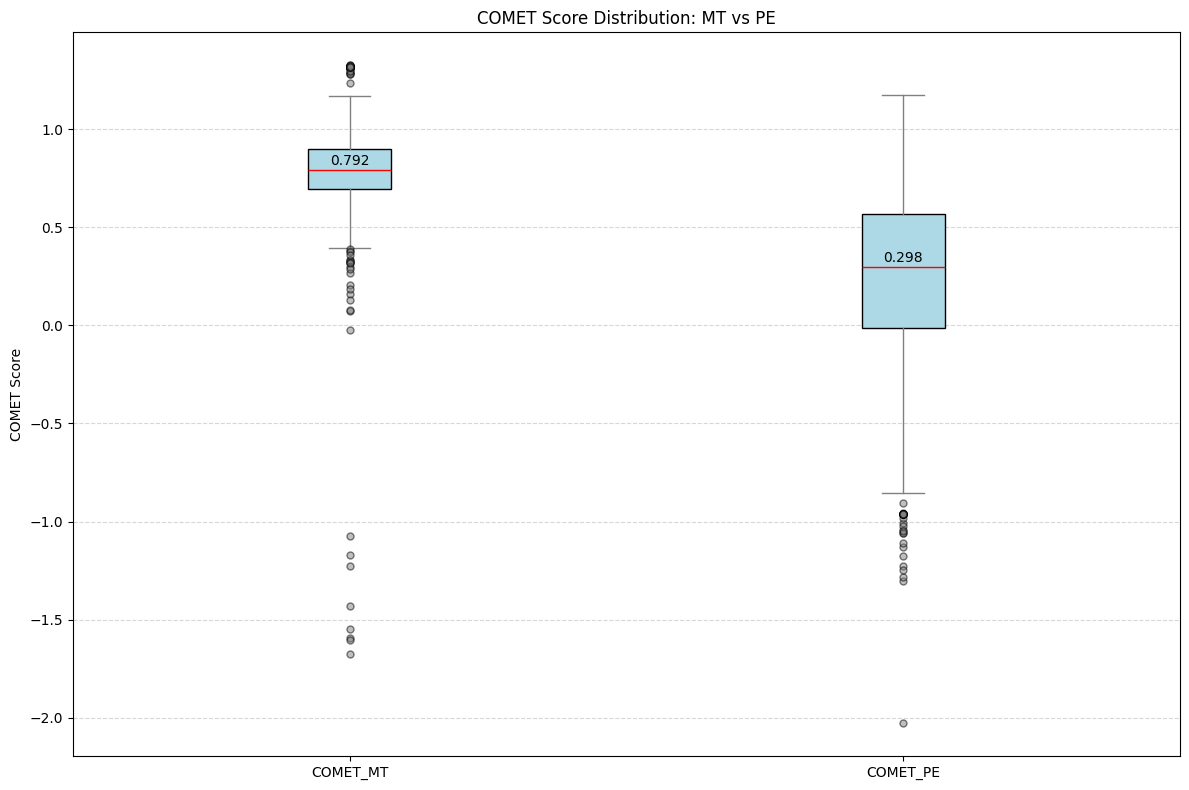

In [16]:
boxdata = [res['COMET_MT'], res['COMET_PE']]
labels = ['COMET_MT', 'COMET_PE']
medians = [s.median() for s in data]

plt.figure(figsize=(12, 8))
box = plt.boxplot(boxdata, tick_labels=labels, patch_artist=True,
                  boxprops=dict(facecolor='lightblue'),
                  medianprops=dict(color='red'),
                  whiskerprops=dict(color='gray'),
                  capprops=dict(color='gray'),
                  flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, alpha=0.5))

# Annotate median values
for i, median in enumerate(medians, start=1):  # boxplot x positions start at 1
    plt.text(i, median + 0.01, f"{median:.3f}", ha='center', va='bottom', fontsize=10, color='black')

plt.ylabel('COMET Score')
plt.title('COMET Score Distribution: MT vs PE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


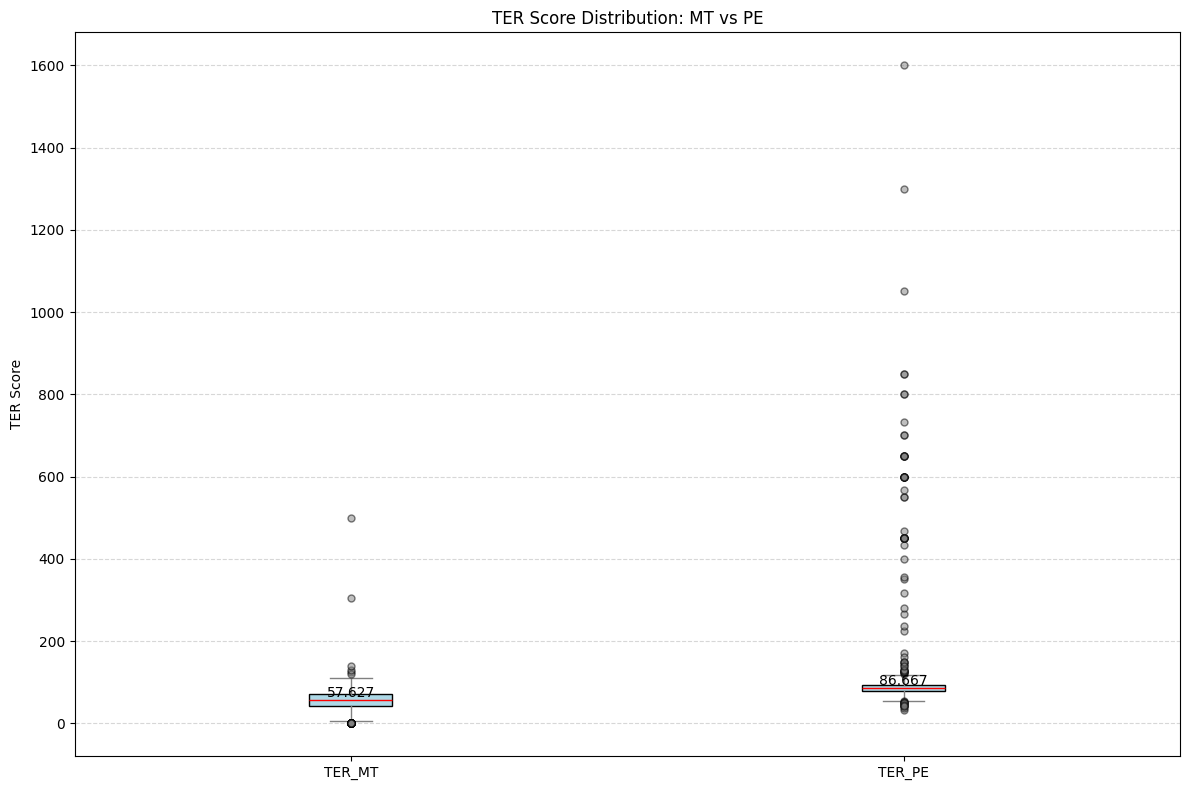

In [18]:
boxdata = [res['TER_MT'], res['TER_PE']]
labels = ['TER_MT', 'TER_PE']
medians = [s.median() for s in data]

plt.figure(figsize=(12, 8))
box = plt.boxplot(boxdata, tick_labels=labels, patch_artist=True,
                  boxprops=dict(facecolor='lightblue'),
                  medianprops=dict(color='red'),
                  whiskerprops=dict(color='gray'),
                  capprops=dict(color='gray'),
                  flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, alpha=0.5))

for i, median in enumerate(medians, start=1):  # boxplot x positions start at 1
    plt.text(i, median + 0.01, f"{median:.3f}", ha='center', va='bottom', fontsize=10, color='black')

plt.ylabel('TER Score')
plt.title('TER Score Distribution: MT vs PE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [128]:
average_delta_abs_COMET = (res["COMET_MT"] - res["COMET_PE"]).abs().mean()
print(f"Average absolute delta (COMET_MT − COMET_PE): {average_delta_abs_COMET:.4f}")
average_delta_abs_TER = (res["TER_MT"] - res["TER_PE"]).abs().mean()
print(f"Average absolute delta (TER_MT − TER_PE): {average_delta_abs_TER:.4f}")


Average absolute delta (COMET_MT − COMET_PE): 0.6121
Average absolute delta (TER_MT − TER_PE): 75.0284


In [9]:
max_delta_abs_COMET = (res["COMET_MT"] - res["COMET_PE"]).abs().max()
print(f"Maximum absolute delta (COMET_MT − COMET_PE): {max_delta_abs_COMET:.4f}")
max_delta_abs_TER = (res["TER_MT"] - res["TER_PE"]).abs().max()
print(f"Maximum absolute delta (TER_MT − TER_PE): {max_delta_abs_TER:.4f}")

Maximum absolute delta (COMET_MT − COMET_PE): 2.9583
Maximum absolute delta (TER_MT − TER_PE): 1550.0000


In [10]:
res["COMET_DELTA_ABS"] = (res["COMET_MT"] - res["COMET_PE"]).abs()

# Find the index of the max delta
max_delta_idx = res["COMET_DELTA_ABS"].idxmax()

# Print the row and the delta
print("Row with max absolute COMET delta:")
print(res.loc[max_delta_idx])
print(f"\n Max absolute COMET delta: {res.loc[max_delta_idx, 'COMET_DELTA_ABS']:.4f}")

Row with max absolute COMET delta:
FR                 2. Les États Membres devraient respecter les p...
RU_GOLD            2. Государства-члены должны соблюдать следующи...
RU_MT              2. Государства-члены должны соблюдать принципы...
FR_TERMS           [États Membres, Déclaration de Rio sur l'envir...
RU_TERMS_GOLD      [государства-члены, Рио-де-Жанейрская декларац...
COMET_MT                                                    0.929502
TER_MT                                                     23.076923
RU_PE              Государства-члены обязаны соблюдать принципы, ...
COMET_PE                                                   -2.028844
TER_PE                                                    354.945055
COMET_DELTA_ABS                                             2.958346
Name: 347, dtype: object

 Max absolute COMET delta: 2.9583


In [126]:
res["TER_DELTA_ABS"] = (res["TER_MT"] - res["TER_PE"]).abs()

# Find the index of the max delta
max_delta_idx = res["TER_DELTA_ABS"].idxmax()

# Print the row and the delta
print("Row with max absolute TER delta:")
print(res.loc[max_delta_idx])
print(f"\n Max absolute TER delta: {res.loc[max_delta_idx, 'TER_DELTA_ABS']:.4f}")

Row with max absolute TER delta:
FR                                                RÉSOLUTION 62/93
RU_GOLD                                            РЕЗОЛЮЦИЯ 62/93
RU_MT                                 Французский: РЕЗОЛЮЦИЯ 62/93
FR_TERMS                                            ['RÉSOLUTION']
RU_TERMS_GOLD                                        ['РЕЗОЛЮЦИЯ']
COMET_MT                                                  0.639425
TER_MT                                                        50.0
RU_PE            Резолюция 62/93 — это документ ООН, который бы...
COMET_PE                                                 -1.059084
TER_PE                                                      1600.0
TER_DELTA_ABS                                               1550.0
Name: 153, dtype: object

 Max absolute TER delta: 1550.0000


### Segement line chart

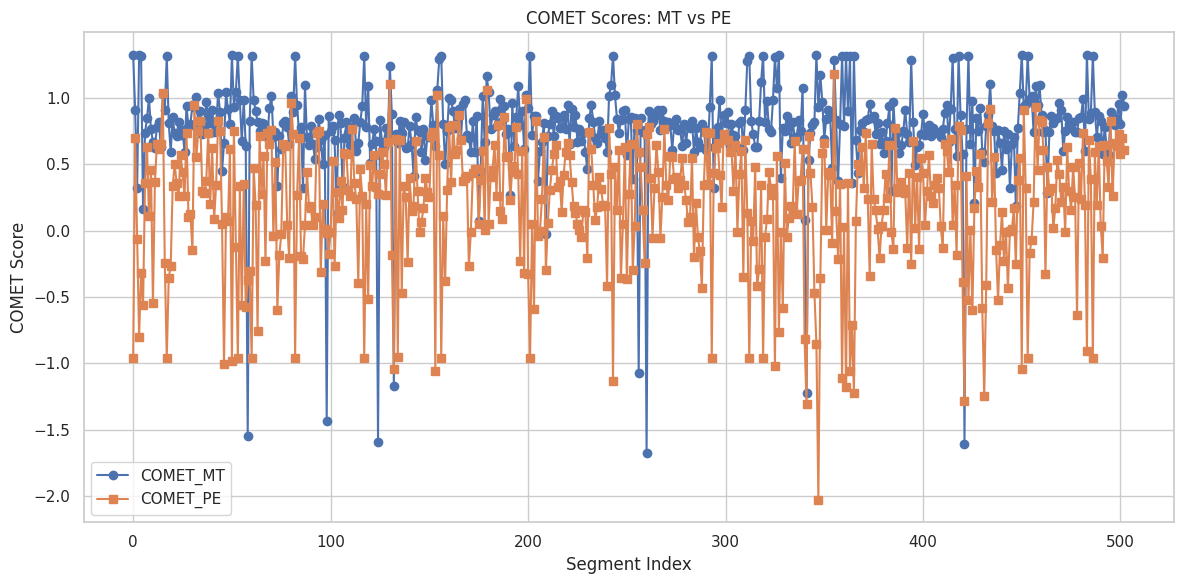

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(res["COMET_MT"], label="COMET_MT", marker="o")
plt.plot(res["COMET_PE"], label="COMET_PE", marker="s")
plt.title("COMET Scores: MT vs PE")
plt.xlabel("Segment Index")
plt.ylabel("COMET Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


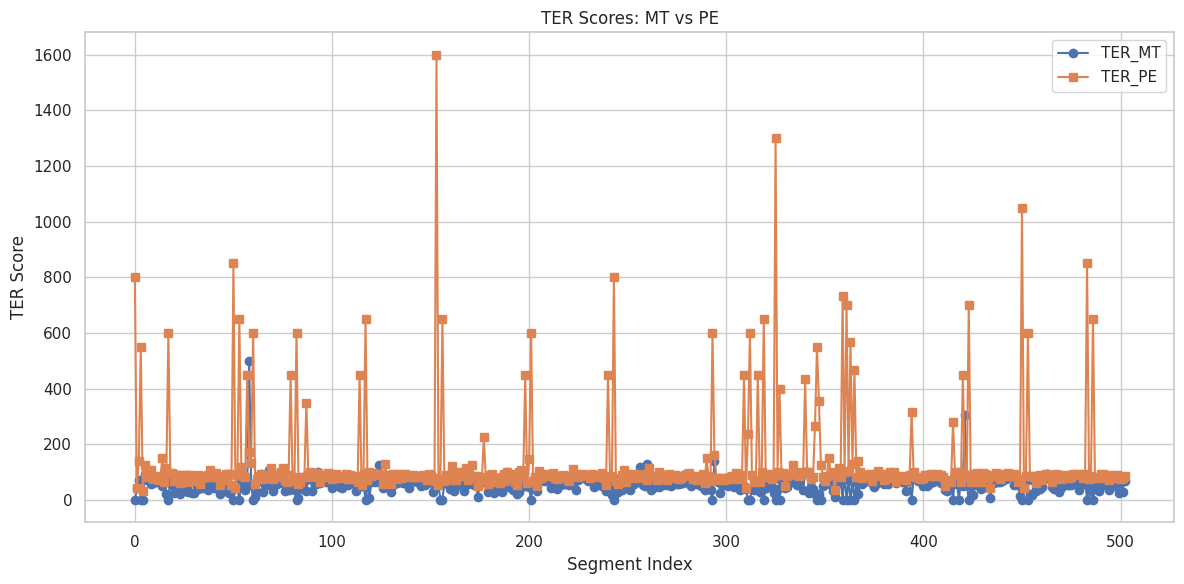

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(res["TER_MT"], label="TER_MT", marker="o")
plt.plot(res["TER_PE"], label="TER_PE", marker="s")
plt.title("TER Scores: MT vs PE")
plt.xlabel("Segment Index")
plt.ylabel("TER Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
